In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
import os
import matplotlib.pyplot as plt

In [2]:
# Population data and the census data, also extract the total and studied attributes
folder_loc = "data/synpop_related"
to_analyse_data = {
    # "SAA_hhsz_rm30": "SAA_HH_oriseed_IPL_abs_hhsz_first_no_penal_rm0_add_zero_cells.csv",
    # "SAA_hhsz_rm0": "SAA_HH_oriseed_IPL_abs_hhsz_first_no_penal_rm30_add_zero_cells.csv",
    # "SAA_hhsz_zerocellstill": "SAA_HH_oriseed_IPL_abs_hhsz_first_no_penal_rm30_missing_zero_cells.csv",
    "SAA_BN_pool": "SAA_HH_paper_BN_IPL_ordered_rm30_2.csv",
    "SAA_seed_addzero": "SAA_HH_paper_oriseed_IPL_ordered_rm30_addzero.csv",
    "SAA_seed_misszero": "SAA_HH_paper_oriseed_IPL_ordered_rm30_misszero.csv",
    "IPF_normal": "IPF_using_normals_seed.csv",
    "IPF_fromBN": "IPF_BN_pool2.csv",
    "WGAN_hhsz": "sampled_wgan_syn.csv",
    "BN_hhsz": "sampled_BN_syn.csv",
    "seed": "hh_sample_ipu.csv", # Main one always there
}
assert "seed" in to_analyse_data

In [3]:
color_code = {
    "SAA_BN_pool": "#1f77b4",
    "SAA_seed_addzero": "#ff7f0e",
    "SAA_seed_misszero": "#2ca02c",
    "IPF_normal": "#d62728",
    "IPF_fromBN": "#9467bd",
    "WGAN_hhsz": "#8c564b",
    "BN_hhsz": "#e377c2",
}

In [4]:
# Reading the file to df
processed_analyse_data = {name: pd.read_csv(os.path.join(folder_loc, file)) for name, file in to_analyse_data.items() if name != "seed"}

C:\Users\dlaa0001\AppData\Local\Temp\ipykernel_19812\240776870.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  processed_analyse_data = {name: pd.read_csv(os.path.join(folder_loc, file)) for name, file in to_analyse_data.items() if name != "seed"}


In [5]:
seed = pd.read_csv(os.path.join(folder_loc, to_analyse_data["seed"]))

In [6]:
census = pd.read_csv(os.path.join(folder_loc, "hh_marginals_ipu.csv"), header=[0,1])

In [7]:
atts = set(census.columns.get_level_values(0)) - {"sample_geog", "zone_id"}
census.columns = census.columns.to_flat_index()

In [8]:
def get_jsd(sum_target: pd.Series, sum_truth:pd.Series):
    # if att == "hhinc" and "Negative income" in sum_df.index:
    #     sum_df = sum_df.drop(index="Negative income")
    p, q = sum_target.align(sum_truth, fill_value=0)

    # Convert to NumPy arrays
    p_array = p.to_numpy()
    q_array = q.to_numpy()

    # Compute Jensen-Shannon Distance
    js_distance = jensenshannon(p_array, q_array)
    return js_distance
    # print(f"Jensen-Shannon Distance for {att}: {js_distance}")


def wrapper_get_jsd_by_att(att: str, df: pd.DataFrame, seed: pd.DataFrame):
    sum_df = df[att].astype(str).value_counts(normalize=True)
    sum_seed = seed[att].astype(str).value_counts(normalize=True)
    return get_jsd(sum_df, sum_seed)

In [9]:
updated_results = {}
for name, df in processed_analyse_data.items():
    hold = {}
    for att in atts:
        hold[att] = wrapper_get_jsd_by_att(att, df, seed)
    updated_results[name] = pd.Series(hold)

In [10]:
# process census
census_hold = {}
for att in atts:
    sub_census = census[[x for x in census.columns if att == x[0]]]
    sum_census = sub_census.sum() / sub_census.sum().sum()
    sum_census.index = [x[1] for x in sum_census.index]

    sum_seed = seed[att].astype(str).value_counts(normalize=True)
    
    # Compute Jensen-Shannon Distance
    census_hold[att] = get_jsd(sum_census, sum_seed)
updated_results["census"] = pd.Series(census_hold)

In [11]:
last_order = ["hhsize", "totalvehs", "hhinc", "dwelltype", "owndwell"]
jsd_results = pd.DataFrame(updated_results).reindex(last_order)
jsd_results = jsd_results.drop(columns=["census"])
jsd_results

,SAA_BN_pool,SAA_seed_addzero,SAA_seed_misszero,IPF_normal,IPF_fromBN,WGAN_hhsz,BN_hhsz
hhsize,0.075489,0.075458,0.074765,0.069133,0.075346,0.075489,0.075489
totalvehs,0.043038,0.043108,0.042754,0.041844,0.043243,0.023141,0.013424
hhinc,0.187654,0.187553,0.180602,0.180920,0.187525,0.123193,0.083078
dwelltype,0.117351,0.117091,0.117044,0.117088,0.117315,0.065454,0.003152
owndwell,0.091831,0.091189,0.091235,0.089448,0.092411,0.018026,0.004210


<Axes: ylabel='JSD against seed'>

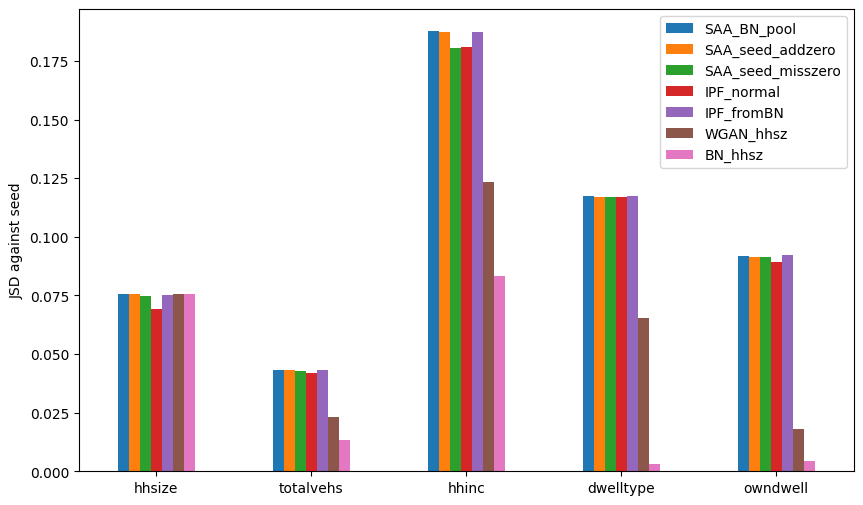

In [12]:
jsd_results.plot(kind='bar', figsize=(10, 6), rot=0, ylabel="JSD against seed",color=[color_code[x] for x in jsd_results.columns])

### Check special case of hhsize

In [13]:
check_att = "hhinc"
possible_states = [x[1] for x in census.columns if x[0] == check_att]

In [14]:
prob_hhsz = {name: df[check_att].astype("str").value_counts(normalize=True) for name, df in processed_analyse_data.items()}
prob_hhsz["seed"] = seed[check_att].astype("str").value_counts(normalize=True)

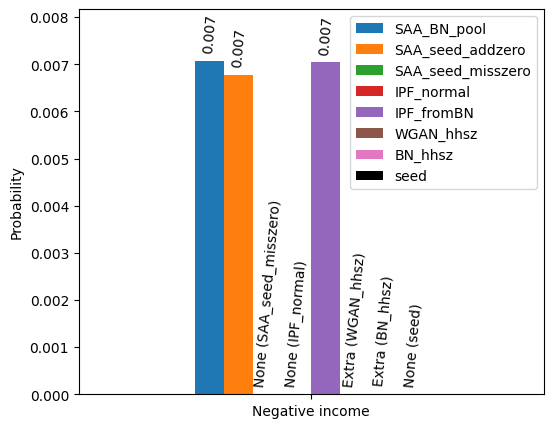

In [15]:
# Create the bar plot
temp_df = pd.DataFrame(prob_hhsz)
expected_colors = [color_code[x] for x in temp_df.columns if x != "seed"]
expected_colors.append("#000000")
ax = temp_df[temp_df.index=="Negative income"].plot(kind='bar', figsize=(6, 5), ylabel="Probability", xlabel="", color=expected_colors)

# Set x-axis labels to be horizontal
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")

# Adjust y-axis limits to create space for labels
ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] * 1.1)  # Increase upper limit by 10%

# Define a threshold for distinguishing "Nothing" (true zero) vs. "Extreme" (very small)
threshold = 1e-4  # Adjust this value based on your dataset

# Get column names from the DataFrame (these correspond to the legend labels)
column_labels = temp_df.columns.tolist()

# Add custom labels
for container, col_name in zip(ax.containers, column_labels):
    labels = []
    for val in container.datavalues:
        if val == 0:
            labels.append(f"None ({col_name})")  # True zero
        elif abs(val) < threshold:
            labels.append(f"Extra ({col_name})")  # Very small number
        else:
            labels.append(f"{val:.3f}")  # Normal number with 4 decimals
    ax.bar_label(container, labels=labels, padding=5, rotation=85)

# Show the plot
plt.show()

In [16]:


# def process_to_marg_form(df: pd.DataFrame, att: str, possible_states: list[str]):
#     att_values = df[[att, "zone_id"]].value_counts().reset_index().pivot(index="zone_id", columns=att, values="count").fillna(0)
#     att_values = df[[att, "zone_id"]].value_counts().reset_index().pivot(index="zone_id", columns=att, values="count").fillna(0)
#     missing_states = set(possible_states) - set(att_values.columns)
#     if len(missing_states) > 0:
#         for state in missing_states:
#             att_values[state] = 0
#     return att_values


# def wrapper_check_jsd_by_state(att: str, states: list[str], target: pd.DataFrame, truth: pd.DataFrame):
#     processed_target = process_to_marg_form(target, att, states)
#     processed_truth = process_to_marg_form(truth, att, states)
    
#     for state in states:
#         sum_target = processed_target[state] / processed_target[state].sum()
#         sum_truth = processed_truth[state] / processed_truth[state].sum()
#         print(f"JSD for {state}: {get_jsd(sum_target, sum_truth)}")

# wrapper_check_jsd_by_state(check_att, possible_states, processed_analyse_data["IPF_normal"], seed)